# Step 1: Data Preprocessing

In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [465]:
df = pd.read_csv("online_retail_10k.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [466]:
df['TotalAmount'] = df['Quantity'] * df['Price']

In [467]:
df['Customer ID'].isnull().sum()

2895

In [468]:
df = df.dropna(subset = ['Customer ID'])

In [469]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
TotalAmount    float64
dtype: object

In [470]:
df = df[~df['Invoice'].str.startswith('C')]

In [471]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [472]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

 # Step 2: RFM Feature Engineering

* Recency – Days since the last purchase

* Frequency – Number of unique invoices per customer

* Monetary – Total spend per customer

In [475]:
# Reference date = max InvoiceDate + 1 day
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days = 1)
ref_date

Timestamp('2009-12-05 09:31:00')

In [476]:
# RFM Calculation
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda x:(ref_date - x.max()).days, 'Invoice': 'nunique', 'TotalAmount': 'sum'}).reset_index()
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12362.0,3,1,130.00
1,12435.0,2,1,1008.00
2,12437.0,2,1,578.28
3,12490.0,3,1,603.94
4,12533.0,3,1,929.92


In [477]:
rfm.describe()

,Customer ID,Recency,Frequency,Monetary
count,283.000000,283.000000,283.000000,283.000000
mean,15418.660777,1.929329,1.187279,597.483180
std,1623.202259,0.847580,0.633224,1432.794509
min,12362.000000,1.000000,1.000000,2.100000
25%,14070.500000,1.000000,1.000000,197.650000
50%,15413.000000,2.000000,1.000000,314.220000
75%,16855.000000,3.000000,1.000000,574.260000
max,18229.000000,4.000000,7.000000,20761.240000


In [478]:
# removing customers with Monetary <= 0 (due to possible refunds or data entry issues)
rfm = rfm[rfm['Monetary'] > 0]

# Step 3: Normalize RFM Features

In [480]:
from sklearn.preprocessing import StandardScaler

In [481]:
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_features)

In [482]:
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = ['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,1.265447,-0.296279,-0.326852
1,0.083528,-0.296279,0.287022
2,0.083528,-0.296279,-0.013426
3,1.265447,-0.296279,0.004514
4,1.265447,-0.296279,0.232431


# Step 4: Clustering (with Elbow Method)

In [484]:
from sklearn.cluster import KMeans

In [485]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

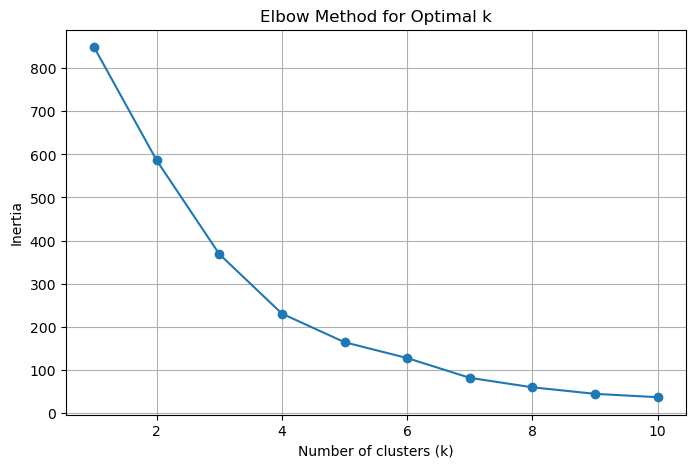

In [486]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Step 5: Segment Analysis & Cluster Profiling

In [488]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(rfm_scaled_df)

rfm['Cluster'] = kmeans.labels_
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12362.0,3,1,130.00,1
1,12435.0,2,1,1008.00,1
2,12437.0,2,1,578.28,1
3,12490.0,3,1,603.94,1
4,12533.0,3,1,929.92,1


In [489]:
cluster_profile  = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'}).rename(columns={'Customer ID': 'CustomerCount'})
cluster_profile 

,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
0,1.000000,1.126214,489.370971,103
1,2.517442,1.093023,424.858256,172
2,1.250000,4.000000,5700.863750,8


In [490]:
cluster_profile = cluster_profile.sort_values(by='Monetary', ascending=False)

In [491]:
cluster_profile = cluster_profile.round(2)

cluster_profile

,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
2,1.25,4.00,5700.86,8
0,1.00,1.13,489.37,103
1,2.52,1.09,424.86,172


##### Insights per Cluster
* Cluster 3 – VIP Customer
    - top customer — they spend the most and buy regularly.
* Cluster 2 – Loyal High Spenders
    - These are very active and valuable customers. 
* Cluster 1 – At-Risk Customers
    - They’re at risk of churn or already inactive.
* Cluster 0 – Recent New Customers
    - These are new or trial customers. 

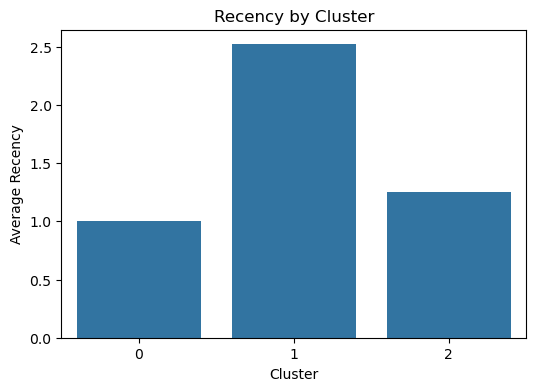

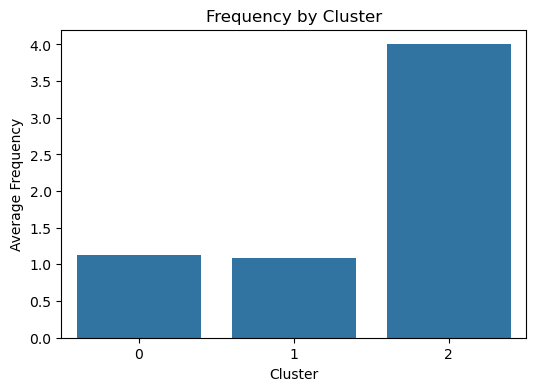

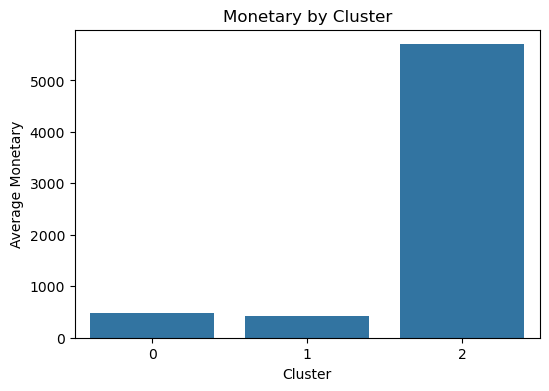

In [493]:
for metric in ['Recency', 'Frequency', 'Monetary']:
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Cluster', y=metric, data=cluster_profile.reset_index())
    plt.title(f'{metric} by Cluster')
    plt.ylabel(f'Average {metric}')
    plt.show()


In [494]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_df)


pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm['Cluster']


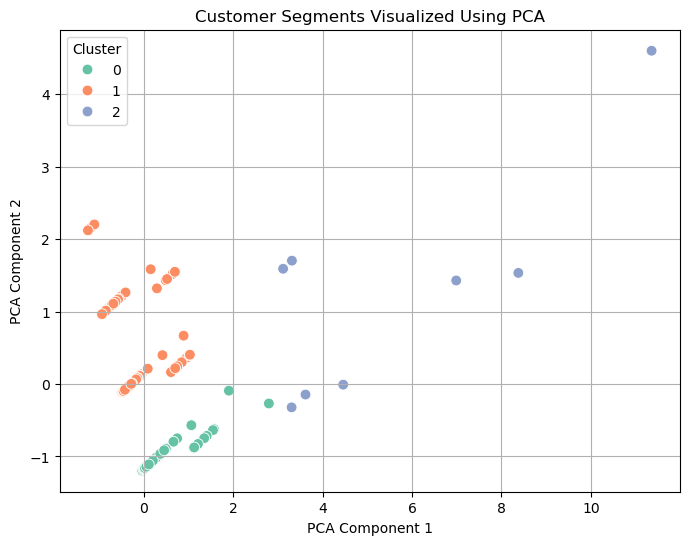

In [495]:


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='Set2',
    s=60
)
plt.title('Customer Segments Visualized Using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [496]:
rfm.to_csv('rfm_clusters.csv', index=False)
